In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

In [2]:
# Veriyi yükle
url = "https://raw.githubusercontent.com/datasets/finance-vix/main/data/vix-daily.csv"  # Örnek veri seti
df = pd.read_csv(url)
df.head()

,DATE,OPEN,HIGH,LOW,CLOSE
0,01/02/1990,17.24,17.24,17.24,17.24
1,01/03/1990,18.19,18.19,18.19,18.19
2,01/04/1990,19.22,19.22,19.22,19.22
3,01/05/1990,20.11,20.11,20.11,20.11
4,01/08/1990,20.26,20.26,20.26,20.26


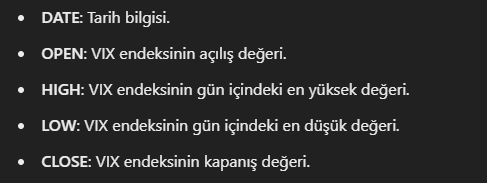

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8803 entries, 0 to 8802
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    8803 non-null   object 
 1   OPEN    8803 non-null   float64
 2   HIGH    8803 non-null   float64
 3   LOW     8803 non-null   float64
 4   CLOSE   8803 non-null   float64
dtypes: float64(4), object(1)
memory usage: 344.0+ KB


In [7]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE')
prices = df[['CLOSE']]

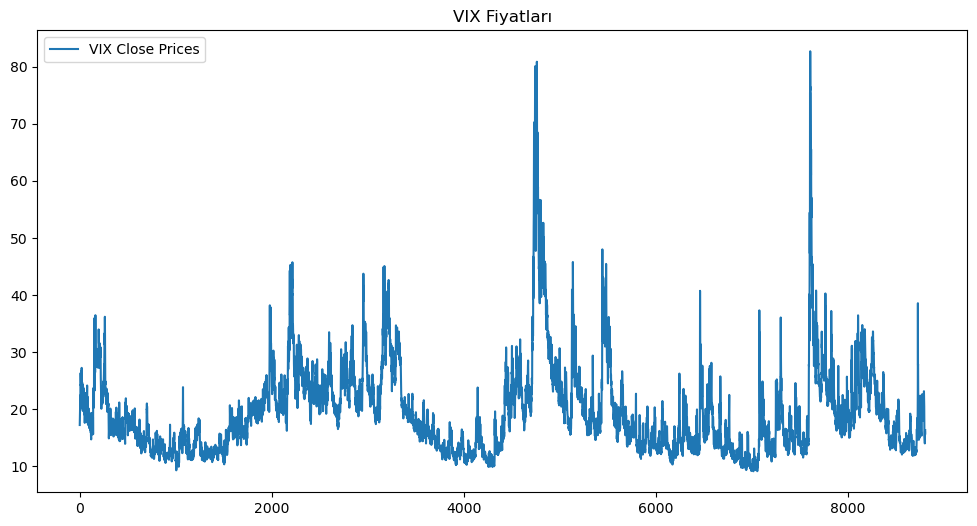

In [8]:
# Fiyat grafiğini çiz
plt.figure(figsize=(12, 6))
plt.plot(prices, label='VIX Close Prices')
plt.title("VIX Fiyatları")
plt.legend()
plt.show()

In [ ]:
# Veriyi Ölçekle

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

scaled_prices[:5]

#Fiyatları [0, 1] aralığında normalize ettik (DL modelleriyle daha iyi çalışması için).

array([[0.11012916],
       [0.12304555],
       [0.13704963],
       [0.14915024],
       [0.15118967]])

In [14]:
# Zaman serisi için veri oluşturma fonksiyonu
def create_datasets(dataset, time_step=10):
    X, Y = [], []
    for i in range(len(dataset) - time_step -1):
        X.append(dataset[i:i + time_step, 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [16]:
#Eğitim ve test setlerini oluştur.

train_size = int(len(scaled_prices) * 0.8)
train_data, test_data = scaled_prices[:train_size], scaled_prices[train_size:] 

time_step = 10
X_train, y_train = create_datasets(train_data, time_step)
X_test, y_test = create_datasets(test_data, time_step)

In [ ]:
# Giriş verisini (samples, time_steps, features) şekline getirme
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Eğitim Veri Şekli: {X_train.shape}, Test Veri Şekli: {X_test.shape}")

Eğitim Veri Şekli: (7031, 10, 1), Test Veri Şekli: (1750, 10, 1)


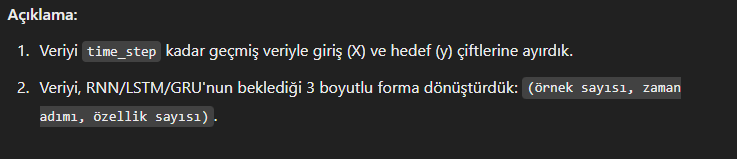

---

## RNN Modeli ile Tahmin

In [18]:
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(time_step, 1)),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Bu kod, bir RNN (Recurrent Neural Network) modeli oluşturuyor. Aşağıda her parametrenin ne anlama geldiğini ve mantığını açıklıyorum:

1. Sequential()
Sequential modeli, katmanları sıralı bir şekilde eklemenizi sağlar. Yani her bir katman, bir önceki katmanın çıktısını giriş olarak alır.
Burada, RNN modeli basit bir sıralı yapı olarak tanımlanmıştır.
2. SimpleRNN Katmanı

SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(time_step, 1))
Parametrelerin Anlamı:
50:
Bu, RNN katmanındaki gizli birimlerin (neurons) sayısını belirtir. Gizli birimlerin sayısı, modelin öğrenme kapasitesini etkiler. Daha fazla birim, daha karmaşık ilişkileri öğrenebilir, ancak aşırı öğrenmeye neden olabilir.

activation='relu':
Aktivasyon fonksiyonu, her nöronun çıktısını belirler.

Burada ReLU (Rectified Linear Unit) kullanılmış. ReLU, negatif değerleri 0'a dönüştürürken pozitif değerleri olduğu gibi bırakır. ReLU, özellikle derin öğrenme modellerinde hızlı ve etkili bir aktivasyon fonksiyonudur.
Alternatifler: tanh, sigmoid.
return_sequences=False:

Bu parametre, katmanın çıktısının bir dizin (sequence) mi yoksa yalnızca son zaman adımının çıktısı mı olacağını belirler.
False: Sadece son zaman adımının çıktısını döndürür (örneğin, tek bir tahmin yapmak için).
True: Her zaman adımındaki çıktıların dizisini döndürür (örneğin, başka bir RNN katmanına bağlanmak için).
input_shape=(time_step, 1):
Bu, modele verilen giriş verisinin boyutlarını tanımlar:

time_step: Zaman adımlarının sayısıdır (örneğin, 10 geçmiş zaman adımı).
1: Her zaman adımında kullanılan özelliklerin sayısıdır (örneğin, fiyat gibi tek bir özellik).
Bu parametre, modelin giriş veri yapısını bilmesi için gereklidir.


Bu kod, bir RNN (Recurrent Neural Network) modeli oluşturuyor. Aşağıda her parametrenin ne anlama geldiğini ve mantığını açıklıyorum:

1. Sequential()
Sequential modeli, katmanları sıralı bir şekilde eklemenizi sağlar. Yani her bir katman, bir önceki katmanın çıktısını giriş olarak alır.
Burada, RNN modeli basit bir sıralı yapı olarak tanımlanmıştır.
2. SimpleRNN Katmanı
python
Kodu kopyala
SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(time_step, 1))
Parametrelerin Anlamı:
50:
Bu, RNN katmanındaki gizli birimlerin (neurons) sayısını belirtir. Gizli birimlerin sayısı, modelin öğrenme kapasitesini etkiler. Daha fazla birim, daha karmaşık ilişkileri öğrenebilir, ancak aşırı öğrenmeye neden olabilir.

activation='relu':
Aktivasyon fonksiyonu, her nöronun çıktısını belirler.

Burada ReLU (Rectified Linear Unit) kullanılmış. ReLU, negatif değerleri 0'a dönüştürürken pozitif değerleri olduğu gibi bırakır. ReLU, özellikle derin öğrenme modellerinde hızlı ve etkili bir aktivasyon fonksiyonudur.
Alternatifler: tanh, sigmoid.
return_sequences=False:

Bu parametre, katmanın çıktısının bir dizin (sequence) mi yoksa yalnızca son zaman adımının çıktısı mı olacağını belirler.
False: Sadece son zaman adımının çıktısını döndürür (örneğin, tek bir tahmin yapmak için).
True: Her zaman adımındaki çıktıların dizisini döndürür (örneğin, başka bir RNN katmanına bağlanmak için).
input_shape=(time_step, 1):
Bu, modele verilen giriş verisinin boyutlarını tanımlar:

time_step: Zaman adımlarının sayısıdır (örneğin, 10 geçmiş zaman adımı).
1: Her zaman adımında kullanılan özelliklerin sayısıdır (örneğin, fiyat gibi tek bir özellik).
Bu parametre, modelin giriş veri yapısını bilmesi için gereklidir.

3. Dense Katmanı
python
Kodu kopyala
Dense(1)
Dense Katmanı:
Dense, tam bağlantılı (fully connected) bir katmandır.
1: Çıktı nöronlarının sayısını belirler. Burada yalnızca 1 nöron var, çünkü tek bir çıktı üretilmesi gerekiyor (örneğin, bir sonraki fiyat tahmini).
Mantığı:
RNN'nin son çıktısı bu katmana gelir ve burada bir tahmin yapılır. Örneğin, zaman serisinin bir sonraki adımındaki fiyat değeri tahmin edilir.

Parametrelerin Anlamı:
optimizer='adam':

Adam Optimizer, modelin ağırlıklarını öğrenmek için kullanılan bir optimizasyon algoritmasıdır.
Adam, öğrenme hızını dinamik olarak ayarlayarak hızlı ve etkili bir şekilde öğrenme sağlar.
loss='mean_squared_error':

Kayıp fonksiyonu, modelin ne kadar hatalı olduğunu ölçer.
Mean Squared Error (MSE), tahmin edilen değer ile gerçek değer arasındaki farkların karelerinin ortalamasını alır. Zaman serisi tahmini gibi regresyon problemlerinde yaygın olarak kullanılır.

Modelin Mantığı
SimpleRNN Katmanı:

Zaman serisi verisindeki bağımlılıkları öğrenir.
Zaman adımları arasındaki ilişkileri modellemek için kullanılır.
Dense Katmanı:

RNN'den gelen çıktıya dayanarak, nihai tahmini yapar (örneğin, bir sonraki fiyat değeri).
Optimizasyon ve Kayıp:

adam optimizasyonu ile model, hata oranını minimize ederek en iyi tahminleri yapmaya çalışır.

In [20]:
# Model Eğitme

rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - val_loss: 8.1161e-04
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3641e-04 - val_loss: 7.5118e-04
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5679e-04 - val_loss: 7.7170e-04
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6945e-04 - val_loss: 7.8983e-04
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4397e-04 - val_loss: 7.4829e-04
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9425e-04 - val_loss: 7.5635e-04
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0320e-04 - val_loss: 7.6592e-04
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6801e-04 - val_loss: 7.6122e-04
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3416e-04 - val_loss: 7.6023e-04
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7953e-04 - val_loss: 8.2677e-04
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.

In [22]:
# Tahmin Yapma
rnn_predictions = rnn_model.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions) # Normalizasyonu geri çevir

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


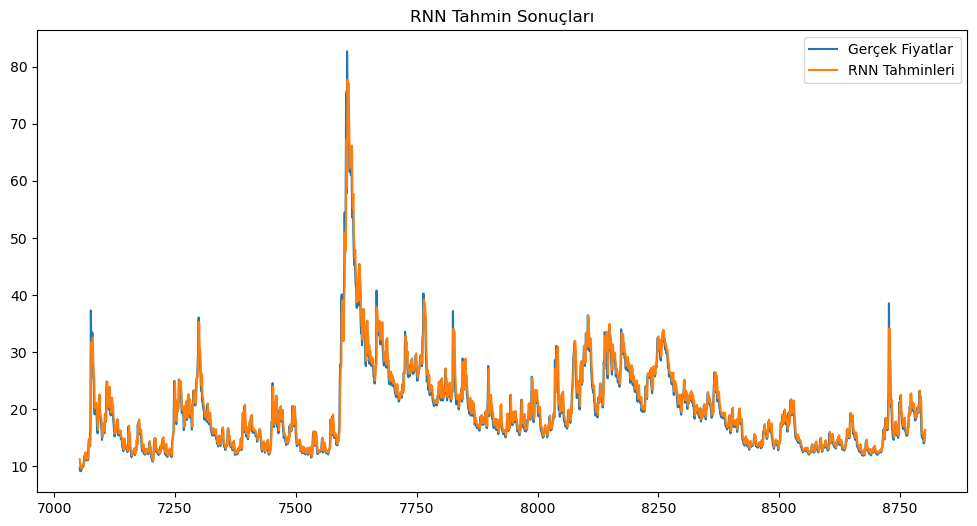

In [23]:
# Test verisini gerçek değerlerle karşılaştır
plt.figure(figsize=(12, 6))
plt.plot(prices.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Gerçek Fiyatlar')
plt.plot(prices.index[-len(rnn_predictions):], rnn_predictions, label='RNN Tahminleri')
plt.title("RNN Tahmin Sonuçları")
plt.legend()
plt.show()

## LSTM ile Tahmin

In [24]:
#LSTM modeli oluşiurma

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=False, input_shape=(time_step, 1)),
    Dense(1)
])

lstm_model.compile(optimizer= 'adam', loss= 'mean_squared_error')

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Model Eğitme

lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

# Tahmin Yapma

lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0095 - val_loss: 0.0018
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5245e-04 - val_loss: 0.0016
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2451e-04 - val_loss: 0.0014
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6810e-04 - val_loss: 0.0012
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.7133e-04 - val_loss: 0.0012
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2780e-04 - val_loss: 0.0012
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1438e-04 - val_loss: 0.0011
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.6228e-04 - val_loss: 0.0010
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7869e-04 - val_loss: 0.0010
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5365e-04 - val_loss: 0.0011
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.7365e-04 - val_loss: 9.0849e-04
Epoch 12

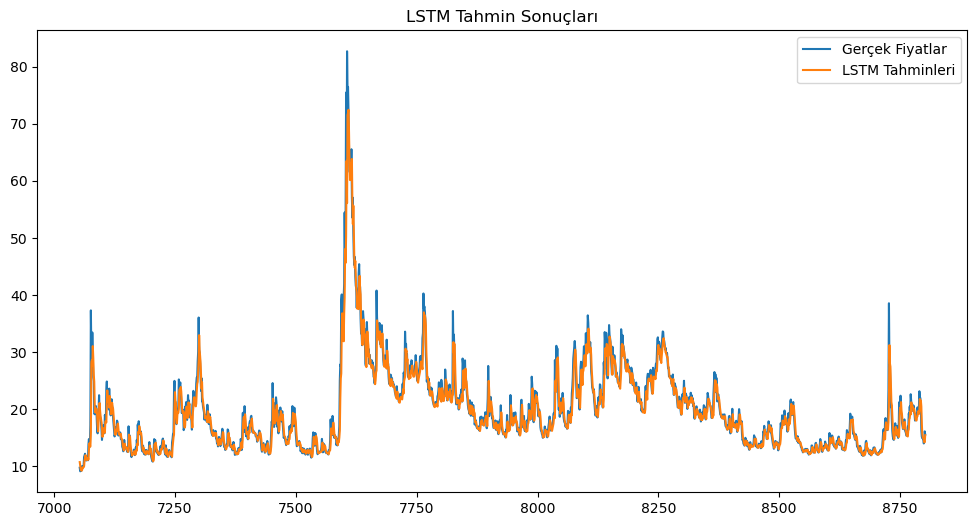

In [26]:
# Tahmin sonuçlarını karşılaştır
plt.figure(figsize=(12, 6))
plt.plot(prices.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Gerçek Fiyatlar')
plt.plot(prices.index[-len(lstm_predictions):], lstm_predictions, label='LSTM Tahminleri')
plt.title("LSTM Tahmin Sonuçları")
plt.legend()
plt.show()

---

## GRU ile Tahmin

In [27]:
# Gru modeli oluşturma

gru_model = Sequential([
    GRU(50, activation='relu', return_sequences=False, input_shape=(time_step, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mean_squared_error')

d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Modeli Eğitme

gru_history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

# Tahmin yapma

gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0066 - val_loss: 9.4305e-04
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2745e-04 - val_loss: 8.7569e-04
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7048e-04 - val_loss: 8.1402e-04
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2836e-04 - val_loss: 7.8014e-04
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1894e-04 - val_loss: 7.7347e-04
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3571e-04 - val_loss: 7.6609e-04
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7574e-04 - val_loss: 7.7700e-04
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2238e-04 - val_loss: 7.5875e-04
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1173e-04 - val_loss: 8.8238e-04
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1800e-04 - val_loss: 7.7235e-04
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.

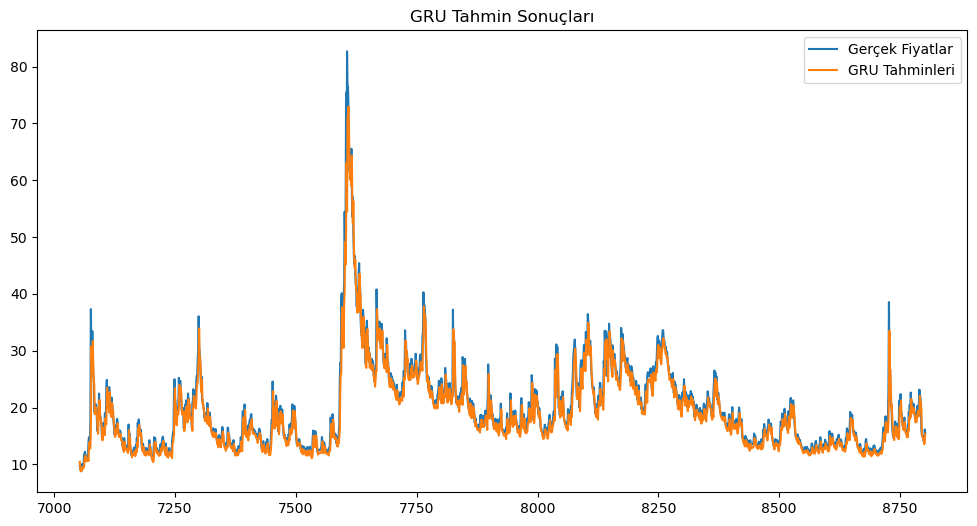

In [30]:
# Tahmin sonuçlarını karşılaştır
plt.figure(figsize=(12, 6))
plt.plot(prices.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Gerçek Fiyatlar')
plt.plot(prices.index[-len(gru_predictions):], gru_predictions, label='GRU Tahminleri')
plt.title("GRU Tahmin Sonuçları")
plt.legend()
plt.show()

---

### 1. RNN Tahmin Sonuçları
Grafik İncelemesi:

Gerçek fiyatlarla RNN tahminleri oldukça yakın gözüküyor.
Özellikle küçük dalgalanmaları iyi yakalamış.
Ancak, fiyatın ani yükseldiği veya düştüğü (örneğin, 7500 çevresinde) yerlerde tahminlerde bir miktar sapma var. RNN, uzun vadeli bağımlılıkları öğrenmekte zorlanabilir.
Genel Durum:

RNN, basit bir mimari olduğundan kısa süreli bağımlılıkları iyi öğrenir.
Ancak, uzun süreli bağımlılıkları anlamada yetersiz kalabilir, bu da büyük trendlerdeki sapmalara neden olabilir.


### 2. LSTM Tahmin Sonuçları
Grafik İncelemesi:

LSTM'nin tahminleri, gerçek fiyatlarla neredeyse örtüşüyor.
Ani yükseliş ve düşüşlerdeki (örneğin, 7500 civarında) performansı, RNN'ye göre daha iyi.
Dalgalanmalara ve büyük trend değişikliklerine uyum sağlayabilmiş.
Genel Durum:

LSTM, unutma ve güncelleme kapıları sayesinde uzun süreli bağımlılıkları daha iyi öğrenir.
Bu da tahminlerin daha doğru olmasını sağlar, özellikle zaman serisi verisinde önemli avantaj sağlar.


### 3. GRU Tahmin Sonuçları
Grafik İncelemesi:

GRU'nun tahminleri, gerçek fiyatlarla çok uyumlu.
Ani yükseliş ve düşüşleri (örneğin, 7500 civarında) oldukça iyi takip edebilmiş.
LSTM'ye çok yakın bir performans sergiliyor.
Genel Durum:

GRU, LSTM'ye benzer şekilde uzun süreli bağımlılıkları öğrenir, ancak daha az karmaşık bir yapıya sahiptir (daha hızlıdır).
Ani değişikliklere ve dalgalanmalara uyum sağlamada başarılı.


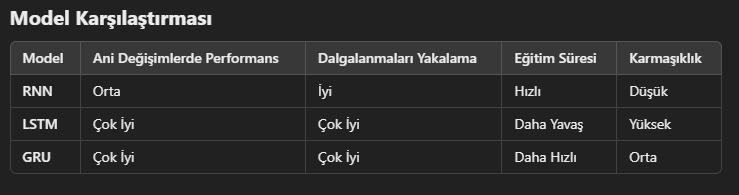

### Sonuç ve Öneri

#### Performans:
* LSTM ve GRU, uzun vadeli bağımlılıkları öğrenmede daha başarılıdır. Bu nedenle, tahmin doğruluğu açısından LSTM ve GRU, RNN'den daha iyidir.

#### Hız:
* GRU, LSTM'ye göre daha hızlıdır ve daha az parametre içerir. Eğer hız önemliyse GRU tercih edilebilir.

#### Seçim:
* Daha yüksek doğruluk: LSTM tercih edilir.
* Daha az karmaşıklık ve hız: GRU tercih edilir.
* Basit model yeterli: RNN tercih edilebilir.

---

# MODEL FARKLILIKLARI


### 1. RNN (Recurrent Neural Network)

#### Avantajları:
* Basitlik: Mimari olarak en temel yapıya sahiptir ve zaman serilerinde kısa süreli bağımlılıkları öğrenmek için uygundur.

* Hız: Daha az karmaşık olduğu için eğitimi ve çıkarımı daha hızlıdır.
Küçük Veri Setleri için İyi: Eğer veri seti küçükse ve bağımlılıklar kısa süreliyse etkili çalışabilir.

#### Dezavantajları:
* Uzun Vadeli Bağımlılık Sorunu: RNN'ler uzun vadeli bağımlılıkları öğrenmekte başarısızdır. Bu, "vanishing gradient" (kaybolan gradyan) probleminden kaynaklanır.
* Performans Kısıtlaması: Karmaşık bağımlılıkları anlamada zayıftır ve doğruluk genellikle sınırlıdır.

#### Ne Zaman Kullanılır?
* Kısa vadeli bağımlılıkların olduğu basit zaman serisi verilerinde.
* Eğitim süresinin çok önemli olduğu ve basit bir modelin yeterli olduğu durumlarda.

---

### 2. LSTM (Long Short-Term Memory)

#### Avantajları:
* Uzun Vadeli Bağımlılıkları Öğrenme: LSTM'nin unutma ve güncelleme kapıları, uzun vadeli bağımlılıkları etkili bir şekilde öğrenmesine olanak tanır.
* Vanishing Gradient Problemine Çözüm: Kapı mekanizmaları sayesinde kaybolan gradyan sorununu büyük ölçüde çözer.
* Esneklik: Farklı türdeki sıralı verilerde oldukça esnek ve etkilidir (ör. zaman serisi, doğal dil işleme, ses verisi).

#### Dezavantajları:
* Karmaşıklık: RNN'ye göre daha fazla parametre içerir, bu da eğitimi daha yavaş hale getirir.
* Hız: GRU'ya göre daha yavaş çalışır.
* Ne Zaman Kullanılır?
* Uzun vadeli bağımlılıkların önemli olduğu durumlarda.
* Karmaşık zaman serisi analizlerinde veya doğal dil işleme gibi görevlerde.

---

### 3. GRU (Gated Recurrent Unit)

#### Avantajları:
* Basitleştirilmiş Kapı Yapısı: GRU, LSTM'ye göre daha az parametreye sahiptir (örneğin, ayrı "forget" ve "input" kapıları yerine tek bir güncelleme kapısı kullanır). Bu, modeli daha hızlı hale getirir.
* Hız: LSTM'ye göre daha hızlı eğitilir ve çıkarım süresi daha kısadır.
* Uzun Vadeli Bağımlılıklar: LSTM'ye benzer şekilde uzun vadeli bağımlılıkları öğrenebilir.

#### Dezavantajları:
* Esneklik: Bazı durumlarda LSTM kadar güçlü olmayabilir (örneğin, çok karmaşık veri setlerinde).


#### Ne Zaman Kullanılır?
* LSTM kadar karmaşık bir yapıya gerek olmayan, ancak uzun vadeli bağımlılıkların olduğu durumlarda.
* Eğitim süresinin kritik olduğu ve hızın önemli olduğu projelerde.

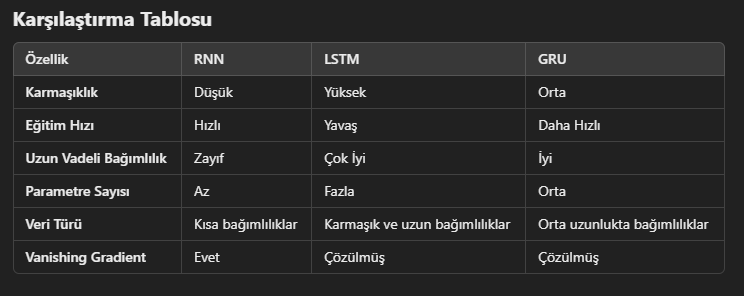